# IoT-Based Agriculture Data: ML Implementation

This implements the machine learning models for the Smart Query Prediction system. It covers:

1.  Connecting to the MonetDB database and building a core dataset.
2.  **Model 1:** A Random Forest Classifier for Crop Recommendation.
3.  **Model 2:** An XGBoost Regressor for Crop Yield Prediction.
4.  **Model 3:** An LSTM Autoencoder for Anomaly Detection in IoT sensor data.
5.  **Final Implementation:** A Smart Alert Engine that combines these models to generate prioritized alerts.

In [ ]:
!pip install --upgrade sqlalchemy sqlalchemy-monetdb xgboost


In [2]:
import pandas as pd
import numpy as np
import pymonetdb
import xgboost as xgb
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from sklearn.preprocessing import MinMaxScaler

# --- MonetDB Connection Details: Update these --- 
db_connection_details = {
    'hostname': 'localhost',
    'port': 50000,
    'username': 'monetdb',
    'password': 'monetdb',
    'database': 'agriDB' # IMPORTANT: Replace with your database name
}

print("Libraries imported and connection details set.")

Libraries imported and connection details set.


In [3]:
# The optimized query now includes a WHERE clause to filter for 'India' and for years after 2000.
# This tells the database to do the heavy lifting, which is much more efficient.
optimized_queryset_sql = """
SELECT
    p.area_name,
    p."year",
    s.value_numeric AS soil_nitrogen_balance,
    t.value_numeric AS avg_jan_temp_change,
    pest.value_numeric AS pesticide_use_kg_ha,
    fert.value_numeric AS nitrogen_fertilizer_tonnes,
    p.item_name AS crop_name,
    p.value_numeric AS crop_yield_hg_ha
FROM
    fao_production AS p
LEFT JOIN fao_soil_nutrient AS s ON p.area_code = s.area_code AND p."year" = s."year" AND s.item_name = 'Soil nutrient budget'
LEFT JOIN fao_temp_change AS t ON p.area_code = t.area_code AND p."year" = t."year" AND t.months_name = 'January'
LEFT JOIN fao_pesticides_use AS pest ON p.area_code = pest.area_code AND p."year" = pest."year"
LEFT JOIN fao_fertilizer_nutrient AS fert ON p.area_code = fert.area_code AND p."year" = fert."year" AND fert.item_name = 'Nutrient nitrogen N (total)'
WHERE
    p.element_name = 'Yield' 
    AND p.value_numeric > 0
    AND p.area_name = 'India' 
    AND p."year" > 2000;
"""

df = None
connection = None # Initialize connection outside try block
try:
    # Using SQLAlchemy engine for better compatibility with pandas.read_sql
    db_url = f"monetdb://{db_connection_details['username']}:{db_connection_details['password']}@{db_connection_details['hostname']}:{db_connection_details['port']}/{db_connection_details['database']}"
    engine = create_engine(db_url)
    connection = engine.connect()
    
    print("Successfully connected to MonetDB.")
    print("Executing optimized query for India (post-2000)...")
    
    # Use the new, faster query
    df = pd.read_sql(optimized_queryset_sql, connection)
    
    print(f"Queryset with {len(df)} rows successfully loaded into a pandas DataFrame.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    if connection is not None:
        connection.close() # Close the SQLAlchemy connection
        print("Database connection closed.")

if df is not None:
    # --- Basic Data Cleaning ---
    for col in df.columns:
        if df[col].isnull().any() and pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].mean())
    
    print("\nDataFrame Info after cleaning:")
    df.info()
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

Successfully connected to MonetDB.
Executing optimized query for India (post-2000)...
Queryset with 149898 rows successfully loaded into a pandas DataFrame.
Database connection closed.

DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149898 entries, 0 to 149897
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   area_name                   149898 non-null  object 
 1   year                        149898 non-null  int64  
 2   soil_nitrogen_balance       149898 non-null  float64
 3   avg_jan_temp_change         149898 non-null  float64
 4   pesticide_use_kg_ha         149898 non-null  float64
 5   nitrogen_fertilizer_tonnes  149898 non-null  float64
 6   crop_name                   149898 non-null  object 
 7   crop_yield_hg_ha            149898 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 9.1+ MB

First 5 rows of the dataset:
 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd

# This assumes 'df' is your main DataFrame loaded from the database cell

# --- Step 1: Create the sample DataFrame ---
# This was the missing step. It creates 'df_sample' from 'df'.
sample_size = 200000 
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df

print(f"Working with a sample of {len(df_sample)} rows.")


# --- Step 2: Prepare data for 'High' vs. 'Low' Yield classification ---
# For each crop in our sample, calculate its historical average yield
df_sample['avg_yield'] = df_sample.groupby('crop_name')['crop_yield_hg_ha'].transform('mean')

# Create a new target: 1 for 'High Yield' (above average), 0 for 'Low Yield'
df_sample['yield_performance'] = (df_sample['crop_yield_hg_ha'] > df_sample['avg_yield']).astype(int)

# --- Define features (X) and target (y) ---
features = ['soil_nitrogen_balance', 'avg_jan_temp_change', 'pesticide_use_kg_ha', 'nitrogen_fertilizer_tonnes']
target_classify = 'yield_performance'

X_classify = df_sample[features]
y_classify = df_sample[target_classify]

# Split the data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_classify, y_classify, test_size=0.2, random_state=42, stratify=y_classify
)

print(f"Data prepared for binary classification (High/Low Yield) with {len(X_train_c)} training samples.")


# --- Step 3: Create and Train the Model using a Pipeline ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))
])

print("\nTraining Model Pipeline...")
pipeline.fit(X_train_c, y_train_c)
y_pred_c = pipeline.predict(X_test_c)


# --- Step 4: Evaluate the Model ---
class_names = ['Low Yield', 'High Yield']
print("\nModel Performance Report (High/Low Yield Classification):")
print(classification_report(y_test_c, y_pred_c, target_names=class_names))

# Display feature importances
feature_importances = pd.DataFrame(
    pipeline.named_steps['classifier'].feature_importances_,
    index=features,
    columns=['importance']
).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Working with a sample of 149898 rows.
Data prepared for binary classification (High/Low Yield) with 119918 training samples.

Training Model Pipeline...

Model Performance Report (High/Low Yield Classification):
              precision    recall  f1-score   support

   Low Yield       0.75      0.72      0.74     15501
  High Yield       0.72      0.75      0.73     14479

    accuracy                           0.74     29980
   macro avg       0.74      0.74      0.74     29980
weighted avg       0.74      0.74      0.74     29980


Feature Importances:
                            importance
soil_nitrogen_balance         0.671877
pesticide_use_kg_ha           0.237701
nitrogen_fertilizer_tonnes    0.058181
avg_jan_temp_change           0.032241


In [5]:
# --- Prepare data for regression ---
df_regress = df.copy()
# For this model, 'crop_name' is a feature, so we encode it
df_regress['crop_name_encoded'] = LabelEncoder().fit_transform(df_regress['crop_name'])

features_regress = ['soil_nitrogen_balance', 'avg_jan_temp_change', 'pesticide_use_kg_ha', 'nitrogen_fertilizer_tonnes', 'crop_name_encoded']
target_regress = 'crop_yield_hg_ha'

X_regress = df_regress[features_regress]
y_regress = df_regress[target_regress]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_regress, y_regress, test_size=0.2, random_state=42)

print("Data prepared for regression.")

# --- Train and Evaluate the Model ---
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining XGBoost Regressor...")
xgbr.fit(X_train_r, y_train_r)
y_pred_r = xgbr.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
print(f"\nModel Root Mean Squared Error (RMSE): {rmse:.2f}")

Data prepared for regression.

Training XGBoost Regressor...

Model Root Mean Squared Error (RMSE): 497.07


2025-11-21 18:37:59.242820: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-21 18:37:59.242859: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-21 18:37:59.242862: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-21 18:37:59.243129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-21 18:37:59.243141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training LSTM Autoencoder...
Epoch 1/5


2025-11-21 18:38:00.226550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.3054 - val_loss: 0.2585
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.2056 - val_loss: 0.2528
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.1321 - val_loss: 0.1960
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.1076 - val_loss: 0.1239
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0759 - val_loss: 0.0720
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step

Detected 70 anomalies based on a threshold of 0.112.


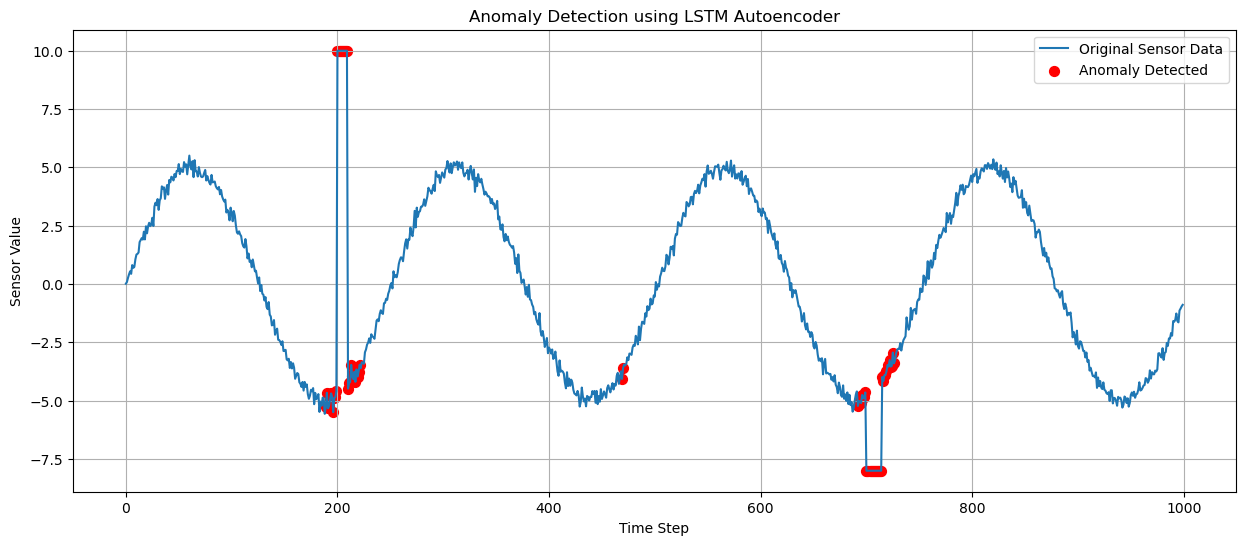

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Generate Synthetic Sensor Data ---
time = np.arange(0, 500, 0.5)
normal_data = np.sin(time / 20) * 5 + np.random.normal(0, 0.2, len(time))
anomalous_data = normal_data.copy()
anomalous_data[200:210] = 10   # Inject a sudden spike anomaly
anomalous_data[700:715] = -8  # Inject a sudden drop anomaly

# --- 2. Preprocess the Data ---
scaler = MinMaxScaler()
scaler.fit(normal_data.reshape(-1, 1))
scaled_data = scaler.transform(anomalous_data.reshape(-1, 1))

def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length + 1):
        xs.append(data[i:i+seq_length])
    return np.array(xs)

SEQ_LENGTH = 24
train_sequences = create_sequences(scaler.transform(normal_data.reshape(-1, 1)), SEQ_LENGTH)
test_sequences = create_sequences(scaled_data, SEQ_LENGTH)

# --- 3. Build and Train the LSTM Autoencoder ---
inputs = Input(shape=(SEQ_LENGTH, 1))
encoded = LSTM(16, activation='relu')(inputs)
decoded = RepeatVector(SEQ_LENGTH)(encoded)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
output = LSTM(1, activation='sigmoid', return_sequences=True)(decoded)

autoencoder = Model(inputs, output)
autoencoder.compile(optimizer='adam', loss='mae')
print("Training LSTM Autoencoder...")

# --- MODIFIED LINE: Reduced epochs and added verbosity ---
autoencoder.fit(train_sequences, train_sequences, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# --- 4. Detect Anomalies ---
reconstructions = autoencoder.predict(test_sequences)
reconstruction_error = np.mean(np.abs(test_sequences - reconstructions), axis=(1, 2))

train_reconstruction_error = np.mean(np.abs(train_sequences - autoencoder.predict(train_sequences)), axis=(1,2))
anomaly_threshold = np.percentile(train_reconstruction_error, 99)

anomalies = reconstruction_error > anomaly_threshold
print(f"\nDetected {np.sum(anomalies)} anomalies based on a threshold of {anomaly_threshold:.3f}.")

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(anomalous_data, label='Original Sensor Data')
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices + SEQ_LENGTH//2, anomalous_data[anomaly_indices + SEQ_LENGTH//2], color='red', s=50, label='Anomaly Detected')
plt.title('Anomaly Detection using LSTM Autoencoder')
plt.xlabel('Time Step')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# --- PREPARE MODELS FOR ALERT ENGINE ---

# Extract trained RandomForest model from the classification pipeline
rfc = pipeline.named_steps['classifier']

# Recreate and fit LabelEncoder (used earlier in regression)
le = LabelEncoder()
le.fit(df_regress['crop_name'])

# XGBoost Regressor already defined as 'xgbr'

# --- MODIFIED FUNCTION: It now accepts the trained models as arguments ---
def run_alert_engine(latest_iot_data, soil_moisture_series_24hr, rfc_model, le_encoder, xgbr_model):
    """
    Smart Alert Engine that prioritizes anomalies, warnings, and recommendations.
    """
    # --- Priority 1: Urgent Anomaly Detection ---
    scaled_series = scaler.transform(soil_moisture_series_24hr.reshape(-1, 1))
    sequence = scaled_series.reshape(1, SEQ_LENGTH, 1)
    reconstruction = autoencoder.predict(sequence)
    reconstruction_error = np.mean(np.abs(sequence - reconstruction))

    if reconstruction_error > anomaly_threshold:
        return (f"🚨 **URGENT ANOMALY DETECTED!**\n"
                f"Soil moisture pattern is unusual.\n"
                f"Reconstruction error: {reconstruction_error:.3f} "
                f"(Threshold: {anomaly_threshold:.3f})\n"
                f"Check irrigation systems or sensors.")

    # --- Priority 2: Contextual Warnings ---
    if 'soil_nitrogen_ppm' in latest_iot_data and latest_iot_data['soil_nitrogen_ppm'] < 15:
        simulated_yield_impact = 20
        return (f"⚠️ **CONTEXTUAL WARNING!**\n"
                f"Current soil nitrogen is low ({latest_iot_data['soil_nitrogen_ppm']} ppm).\n"
                f"Expected yield reduction: ~{simulated_yield_impact}%.\n"
                f"Consider applying additional nutrients.")

    # --- Priority 3: Proactive Recommendations ---
    input_df = pd.DataFrame([latest_iot_data])
    input_df_rfc = input_df[features]
    # Predict best crop (using the RandomForestClassifier)
    recommended_crop_encoded = rfc_model.predict(input_df_rfc)[0]
    recommended_crop_name = le_encoder.inverse_transform([recommended_crop_encoded])[0]

    input_df_xgbr = input_df[features_regress[:-1]]
    input_df_xgbr['crop_name_encoded'] = recommended_crop_encoded
    predicted_yield = xgbr_model.predict(input_df_xgbr)[0]

    return (f"🌱 **Proactive Recommendation:**\n"
            f"All systems normal.\n"
            f"Suggested crop: **{recommended_crop_name}**.\n"
            f"Predicted yield: **{predicted_yield:.2f} hg/ha** based on current conditions.")

# --- EXAMPLES OF THE ENGINE IN ACTION ---

# Example 1: Anomalous Input
anomalous_series_input = np.linspace(10, 12, SEQ_LENGTH)
latest_data_anomaly = {'soil_nitrogen_ppm': 25}
print("\n--- Running Engine with Anomalous Data ---")
print(run_alert_engine(latest_data_anomaly, anomalous_series_input, rfc, le, xgbr))

# Example 2: Low Nitrogen Warning
true_normal_series_input = normal_data[100 : 100 + SEQ_LENGTH]
latest_data_low_nitrogen = {'soil_nitrogen_ppm': 12}
print("\n--- Running Engine with Low Nitrogen Warning ---")
print(run_alert_engine(latest_data_low_nitrogen, true_normal_series_input, rfc, le, xgbr))

# Example 3: Normal Data (Proactive Recommendation)
latest_data_normal = {
    'soil_nitrogen_balance': 30.0,
    'avg_jan_temp_change': 1.1,
    'pesticide_use_kg_ha': 2.0,
    'nitrogen_fertilizer_tonnes': 180.0,
    'soil_nitrogen_ppm': 45
}
print("\n--- Running Engine with Normal Data ---")
print(run_alert_engine(latest_data_normal, true_normal_series_input, rfc, le, xgbr))



--- Running Engine with Anomalous Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
🚨 **URGENT ANOMALY DETECTED!**
Soil moisture pattern is unusual.
Reconstruction error: 0.519 (Threshold: 0.112)
Check irrigation systems or sensors.

--- Running Engine with Low Nitrogen Warning ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
⚠️ **CONTEXTUAL WARNING!**
Current soil nitrogen is low (12 ppm).
Expected yield reduction: ~20%.
Consider applying additional nutrients.

--- Running Engine with Normal Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
🌱 **Proactive Recommendation:**
All systems normal.
Suggested crop: **Apples**.
Predicted yield: **5686.03 hg/ha** based on current conditions.


/Users/shubhamlakhani/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [8]:
import joblib
from tensorflow.keras.models import save_model

# Save the Scikit-Learn/XGBoost models
joblib.dump(rfc, 'rfc_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(xgbr, 'xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save the Keras/TensorFlow model
save_model(autoencoder, 'lstm_autoencoder.h5')
print("Models saved successfully!")

Models saved successfully!


In [9]:
import sklearn
import xgboost
import tensorflow
import joblib
import pandas
import numpy

print(f"scikit-learn: {sklearn.__version__}")
print(f"xgboost: {xgboost.__version__}")
print(f"tensorflow: {tensorflow.__version__}")
print(f"joblib: {joblib.__version__}")
print(f"pandas: {pandas.__version__}")
print(f"numpy: {numpy.__version__}")

scikit-learn: 1.6.1
xgboost: 3.1.2
tensorflow: 2.16.2
joblib: 1.4.2
pandas: 2.2.3
numpy: 1.26.4
